# Fine Tuning BERT in Python for Disaster Tweets Classification

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

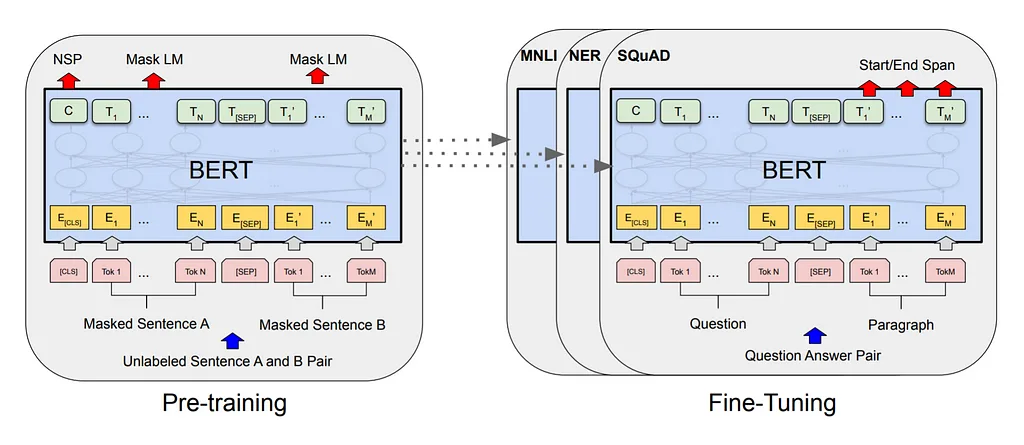

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Real or Not? Disaster Tweets Classifications

In [2]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [3]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [4]:
tweet.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Target Class Distribution

In [7]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

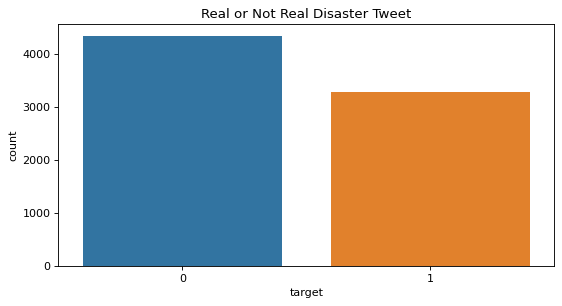

In [8]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [9]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

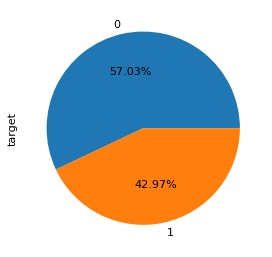

In [60]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [11]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [59]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Word Embeddings and Classification with Deep Learning


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [15]:
text = tweet['text']
print(text)
y = tweet['target']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object


In [16]:
token = Tokenizer()
token.fit_on_texts(text)

In [17]:
vocab_size = len(token.word_index) + 1
vocab_size

22701

In [18]:
print(token.word_index)

{'t': 1, 'co': 2, 'http': 3, 'the': 4, 'a': 5, 'in': 6, 'to': 7, 'of': 8, 'and': 9, 'i': 10, 'is': 11, 'for': 12, 'on': 13, 'you': 14, 'my': 15, 'with': 16, 'that': 17, 'it': 18, 'at': 19, 'by': 20, 'this': 21, 'from': 22, 'https': 23, 'are': 24, 'be': 25, 'was': 26, 'have': 27, 'like': 28, 'amp': 29, 'as': 30, 'up': 31, 'me': 32, 'but': 33, 'just': 34, 'so': 35, 'not': 36, 'your': 37, 'out': 38, 'no': 39, 'all': 40, 'after': 41, 'will': 42, 'an': 43, 'has': 44, 'fire': 45, "i'm": 46, 'when': 47, 'if': 48, 'we': 49, 'get': 50, 'now': 51, 'new': 52, 'via': 53, 'more': 54, '2': 55, 'about': 56, 'or': 57, 'news': 58, 'people': 59, 'what': 60, 'they': 61, 'one': 62, 'he': 63, 'how': 64, 'been': 65, 'over': 66, 'who': 67, "it's": 68, 'into': 69, "don't": 70, 'do': 71, 'video': 72, "'": 73, 'can': 74, 'emergency': 75, 'disaster': 76, 'there': 77, 'police': 78, 'than': 79, '3': 80, 'her': 81, 'u': 82, 'would': 83, 'still': 84, 'his': 85, 'some': 86, 'were': 87, 'body': 88, 'us': 89, 'burning'

In [19]:
encoded_text = token.texts_to_sequences(text)

In [20]:
print(encoded_text)

[[119, 4633, 24, 4, 868, 8, 21, 263, 138, 1619, 4634, 89, 40], [189, 45, 229, 799, 6954, 6955, 1404], [40, 1751, 1620, 7, 6956, 6, 6957, 24, 136, 6958, 20, 1752, 39, 441, 256, 57, 2158, 6, 714, 1405, 24, 1106], [835, 2921, 59, 4635, 1500, 256, 1405, 6, 96], [34, 100, 1221, 21, 320, 22, 6959, 2159, 30, 271, 22, 1500, 6960, 69, 5, 187], [2922, 378, 96, 1501, 800, 869, 6, 665, 6961, 563, 7, 1159, 399, 45, 4636, 1500], [218, 76, 870, 295, 1222, 836, 264, 8, 1753, 6, 6962, 1047, 2453, 1502], [46, 13, 230, 8, 4, 1933, 9, 10, 74, 110, 5, 45, 6, 4, 4637], [422, 43, 75, 256, 1304, 51, 6, 4, 594, 871, 4, 769], [46, 2454, 17, 4, 469, 11, 250, 7, 119, 278], [595, 59, 641, 22, 4, 279, 470, 35, 642], [872, 564, 2923, 11, 231, 2924, 3597, 690, 5, 715, 10, 200, 6, 564, 2923, 60, 175, 10, 321, 71, 60, 175, 10, 321, 71, 6963, 264], [2925, 264, 2160, 6964, 2923, 950, 57, 1934, 619, 358, 738, 3598], [218, 6, 4638, 951, 49, 1754, 4638], [232, 7, 187, 423, 13, 3599, 6, 2926, 130, 92, 359], [716, 31, 104], [

In [21]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [22]:
print(X)

[[ 119 4633   24 ...    0    0    0]
 [ 189   45  229 ...    0    0    0]
 [  40 1751 1620 ...    0    0    0]
 ...
 [2824 2401  709 ...    0    0    0]
 [  78 1145   41 ...    0    0    0]
 [   4  209   54 ...    0    0    0]]


In [23]:
X.shape

(7613, 40)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [25]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2270100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [27]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 4s 12ms/step - loss: 0.6819 - accuracy: 0.5704 - val_loss: 0.6764 - val_accuracy: 0.6330
Epoch 2/5
191/191 [==============================] - 2s 10ms/step - loss: 0.6309 - accuracy: 0.6499 - val_loss: 0.5433 - val_accuracy: 0.7735
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.4505 - accuracy: 0.8051 - val_loss: 0.4728 - val_accuracy: 0.7879
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2900 - accuracy: 0.8874 - val_loss: 0.4851 - val_accuracy: 0.7735
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.1679 - accuracy: 0.9386 - val_loss: 0.5158 - val_accuracy: 0.7814
CPU times: user 12.8 s, sys: 1.82 s, total: 14.6 s
Wall time: 21.5 s


In [28]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [29]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-jrswz8s5
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-jrswz8s5


In [30]:
import preprocess_kgptalkie as kgp

In [31]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [32]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [33]:
vec

array([[ 10, 175,   7, 110,  21,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [34]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [35]:
!pip install ktrain

In [36]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [37]:
from ktrain import text
import ktrain

In [38]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
6909         1.0     0.0
3959         1.0     0.0
2024         1.0     0.0
6178         1.0     0.0
1897         1.0     0.0
['not_target', 'target']
      not_target  target
2813         1.0     0.0
589          1.0     0.0
4286         1.0     0.0
5329         1.0     0.0
7042         0.0     1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [39]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [40]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [41]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 146s 1s/step - loss: 0.5020 - accuracy: 0.7589 - val_loss: 0.3874 - val_accuracy: 0.8399


In [42]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 116s 1s/step - loss: 0.3543 - accuracy: 0.8513 - val_loss: 0.3920 - val_accuracy: 0.8425
Epoch 2/3
108/108 [==============================] - 115s 1s/step - loss: 0.3238 - accuracy: 0.8708 - val_loss: 0.4007 - val_accuracy: 0.8425
Epoch 3/3
108/108 [==============================] - 115s 1s/step - loss: 0.2331 - accuracy: 0.9139 - val_loss: 0.4454 - val_accuracy: 0.8425


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 133s 1s/step - loss: 0.3352 - accuracy: 0.8590 - val_loss: 0.4615 - val_accuracy: 0.8228
Epoch 2/3
108/108 [==============================] - 133s 1s/step - loss: 0.3115 - accuracy: 0.8748 - val_loss: 0.5920 - val_accuracy: 0.7480
Epoch 3/3
108/108 [==============================] - 133s 1s/step - loss: 0.1731 - accuracy: 0.9365 - val_loss: 0.5802 - val_accuracy: 0.8346


In [43]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [44]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [55]:
data[1]

'i got today car accident, i am injured'

In [45]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:215: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  warnings.warn('List or array of two texts supplied, so task being treated as text classification. ' +\


array([[0.91018885, 0.08981112],
       [0.3474569 , 0.65254307]], dtype=float32)

In [46]:
predictor.predict(data[1])

'target'

In [47]:
classes = predictor.get_classes()

In [48]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [56]:
y_pred = predictor.predict(data[0])
classes.index(y_pred)

0

In [57]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)